# Your Title Here

**Name(s)**: (your name(s) here)

**Website Link**: (your website link)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

# from dsc80_utils import * # Feel free to uncomment and use this.


## Step 1: Intro Data Analysis + Data Cleaning
The goal is to take team economy stats as well as individual economy stats afer 15 minutes to try and predict whether or not the team ends up with a win or not. This is to try and determine the importance of trying to get gold for upgrades and other pruposes and farming mobs as comapred to actually fighting with other players from the other team. 

In [117]:
df = pd.read_csv('dsc80finalprojectdata.csv')
df = df[df['gamelength'] >= 15 * 60]
league_df = df[['gameid', 'result', 'league', 
    'goldat15', 'firstdragon', 'damagetochampions', 'killsat15', 
    'earnedgold', 'golddiffat15', 
    'earnedgoldshare', 
    'xpdiffat15', 'csdiffat15',
    'dragons', 'firsttower']]
stats = league_df.describe()
stats
(league_df.isna().sum() / league_df.shape[0]).sort_values()
# Look at proportions of null values -> we can see that the binary values for dragons, first dragon, and first tower are a lot of the time null because it usually is an objective that one person achieves  

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_944/4021580179.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dsc80finalprojectdata.csv')


gameid               0.000000
result               0.000000
league               0.000000
damagetochampions    0.000080
earnedgold           0.000093
goldat15             0.151191
killsat15            0.151191
golddiffat15         0.151191
xpdiffat15           0.151191
csdiffat15           0.151191
earnedgoldshare      0.166667
dragons              0.833333
firstdragon          0.858532
firsttower           0.858532
dtype: float64

In [107]:
league_df.isna().sum().sort_values(ascending=False)

firsttower           128924
firstdragon          128924
firstdragon          128924
dragons              125140
earnedgoldshare       25028
goldat15              22704
csdiffat15            22704
killsat15             22704
xpdiffat15            22704
killsat15             22704
goldat15              22704
golddiffat15          22704
earnedgold               14
damagetochampions        12
result                    0
league                    0
gameid                    0
dtype: int64

In [124]:
df.shape

(150168, 161)

In [126]:
from sklearn.impute import SimpleImputer
numeric_imputer = SimpleImputer(strategy='mean')
def add_team_stats_to_player_rows(df):
    # Group by game and find team stats
    team_stats = df.groupby(['gameid', 'result']).agg({
        'firstdragon': 'first',
        'firsttower': 'first',
        'dragons': 'first'
    }).reset_index()
    
    # Merge these team stats back to the original dataframe
    df_with_team_stats = df.merge(team_stats, on=['gameid', 'result'], how='left', 
                                   suffixes=('', '_team_summary'))
    
    return df_with_team_stats

league_df = add_team_stats_to_player_rows(df)
league_df = league_df[
    ['gameid', 'result',  'position', 'league', 'goldat15', 'firstdragon_team_summary', 'damagetochampions', 
     'killsat15', 'earnedgold', 'golddiffat15', 'earnedgoldshare', 
     'xpdiffat15', 'csdiffat15', 'dragons_team_summary', 'firsttower_team_summary']
].loc[league_df['dragons'].isna()] # gets rid of team stats after applying them to the rest of the individual columns, combiens both team stats and individual econ stats to predict win 


# Wanted to use mean imputaiton based on each position because each role can have different economic stats-> for example a jungler might be the one who goes and tries to get more gold from mobs compared to any of lane players 

numeric_columns = ['goldat15', 'killsat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15']
for col in numeric_columns:
    league_df[col] = league_df.groupby('position')[col].transform(lambda x: x.fillna(x.mean()))
    
#mode imputation for categorical data

league_df['firstdragon_team_summary'] = league_df['firstdragon_team_summary'].fillna(league_df['firstdragon_team_summary'].mode()[0])
league_df['firsttower_team_summary'] = league_df['firsttower_team_summary'].fillna(league_df['firsttower_team_summary'].mode()[0])

#drop rows when either earnedgold or damangetochampions is NaN
league_df = league_df.dropna(subset=['earnedgold', 'damagetochampions'])

league_df.isna().sum() # we can see that the number of null values has gone down a lot more 
(league_df.isna().sum() / league_df.shape[0]).sort_values() # as you can see here, now we have a lot less misisng values and nan values in our data!

gameid                      0.0
result                      0.0
position                    0.0
league                      0.0
goldat15                    0.0
firstdragon_team_summary    0.0
damagetochampions           0.0
killsat15                   0.0
earnedgold                  0.0
golddiffat15                0.0
earnedgoldshare             0.0
xpdiffat15                  0.0
csdiffat15                  0.0
dragons_team_summary        0.0
firsttower_team_summary     0.0
dtype: float64

In [135]:
league_df

gameid  result position league     goldat15  \
0       ESPORTSTMNT01_2690210       0      top   LCKC  5025.000000   
1       ESPORTSTMNT01_2690210       0      jng   LCKC  5366.000000   
2       ESPORTSTMNT01_2690210       0      mid   LCKC  5118.000000   
3       ESPORTSTMNT01_2690210       0      bot   LCKC  5461.000000   
4       ESPORTSTMNT01_2690210       0      sup   LCKC  3836.000000   
...                       ...     ...      ...    ...          ...   
150161       9687-9687_game_5       1      top   DCup  5236.348475   
150162       9687-9687_game_5       1      jng   DCup  5130.463237   
150163       9687-9687_game_5       1      mid   DCup  5455.777914   
150164       9687-9687_game_5       1      bot   DCup  5511.964461   
150165       9687-9687_game_5       1      sup   DCup  3492.126294   

        firstdragon_team_summary  damagetochampions  killsat15  earnedgold  \
0                            0.0            15768.0   0.000000      7164.0   
1                            0.0            11765.0   2.000000      5368.0   
2                            0.0            14258.0   0.000000      5945.0   
3                            0.0            11106.0   2.000000      6835.0   
4                            0.0             3663.0   1.000000      2908.0   
...                          ...                ...        ...         ...   
150161                       0.0            13352.0   0.631049      9832.0   
150162                       0.0             5979.0   1.201186      6271.0   
150163                       0.0            19185.0   0.906326      8667.0   
150164                       0.0            28282.0   0.964884     10416.0   
150165                       0.0            10950.0   0.370881      4811.0   

        golddiffat15  earnedgoldshare  xpdiffat15  csdiffat15  \
0              391.0         0.253859       345.0        14.0   
1              541.0         0.190220      -275.0       -11.0   
2             -475.0         0.210665       153.0         1.0   
3             -793.0         0.242201     -1343.0       -34.0   
4              443.0         0.103054      -497.0         7.0   
...              ...              ...         ...         ...   
150161           0.0         0.245817         0.0         0.0   
150162           0.0         0.156788         0.0         0.0   
150163           0.0         0.216691         0.0         0.0   
150164           0.0         0.260417         0.0         0.0   
150165           0.0         0.120287         0.0         0.0   

        dragons_team_summary  firsttower_team_summary  
0                        1.0                      1.0  
1                        1.0                      1.0  
2                        1.0                      1.0  
3                        1.0                      1.0  
4                        1.0                      1.0  
...                      ...                      ...  
150161                   4.0                      0.0  
150162                   4.0                      0.0  
150163                   4.0                      0.0  
150164                   4.0                      0.0  
150165                   4.0                      0.0  

[125120 rows x 15 columns]

## Step 2: Data Cleaning and Exploratory Data Analysis

            goldat15  damagetochampions      killsat15     earnedgold  \
count  125120.000000      125120.000000  125120.000000  125120.000000   
mean     4965.336076       13339.074624       0.814865    7243.567711   
std       960.718266        8319.966666       1.040773    3063.194627   
min      2433.000000         403.000000       0.000000     439.000000   
25%      4486.000000        7050.000000       0.000000    4855.000000   
50%      5130.463237       11809.000000       0.631049    7145.000000   
75%      5511.964461       17697.000000       1.000000    9281.000000   
max     11723.000000       92366.000000      13.000000   23345.000000   

        golddiffat15  earnedgoldshare     xpdiffat15     csdiffat15  
count  125120.000000    125120.000000  125120.000000  125120.000000  
mean        0.000000         0.200000       0.000000       0.000000  
std       949.077077         0.068002     731.858183      22.590886  
min     -7659.000000         0.033543   -5783.000000    -154.0

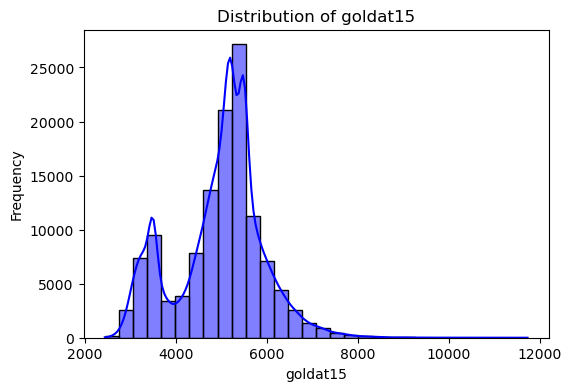

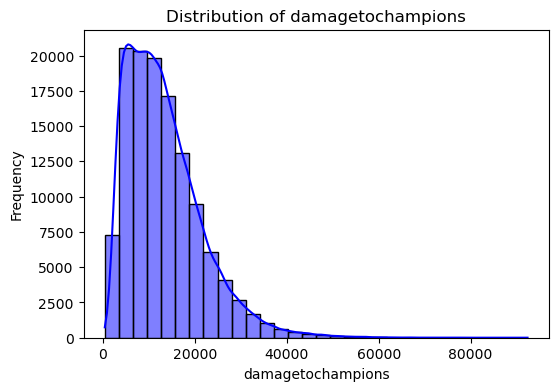

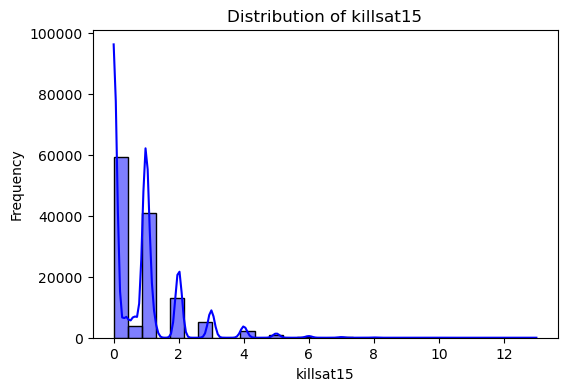

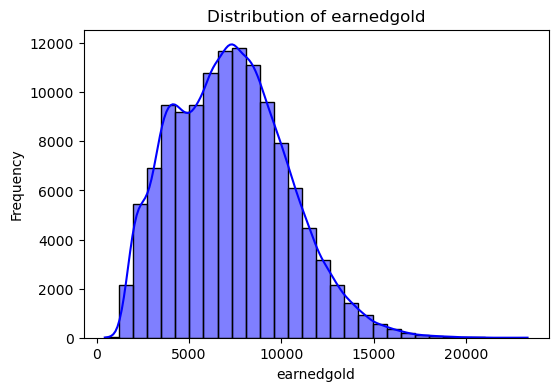

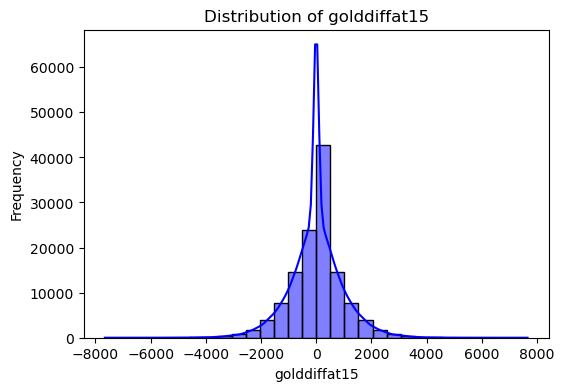

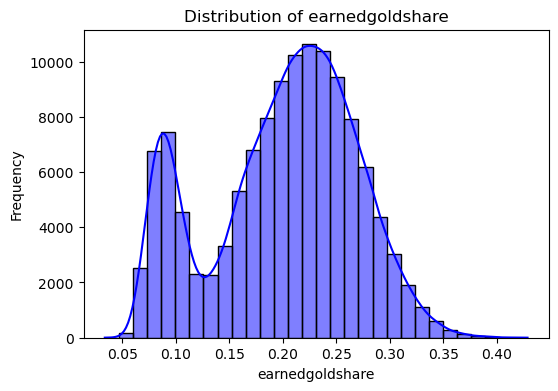

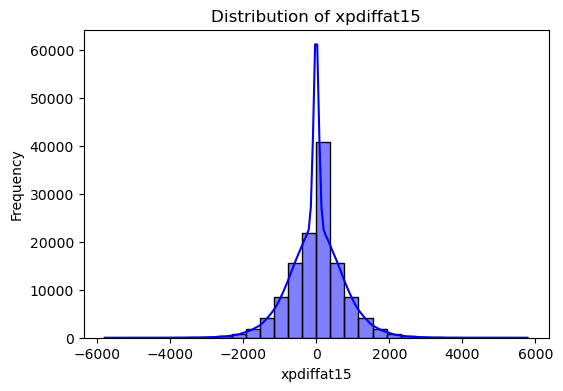

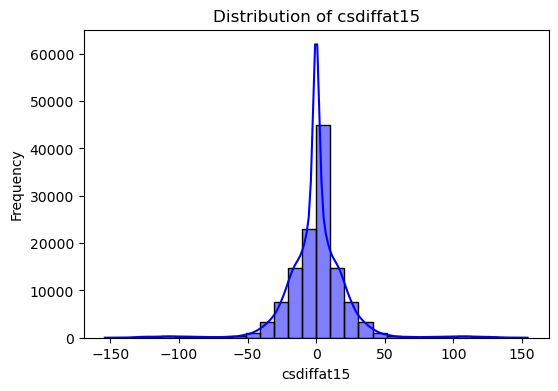

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')


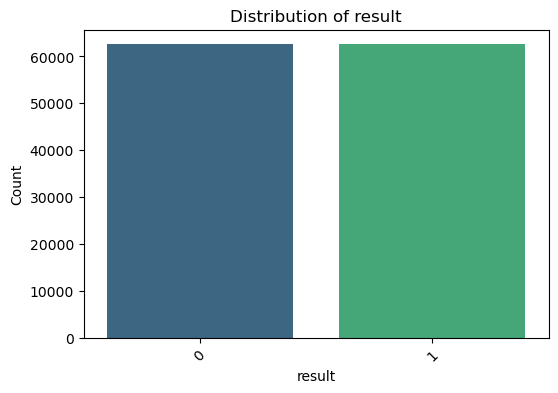

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')


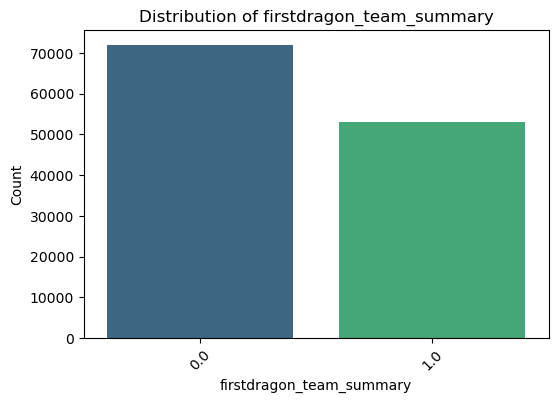

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')


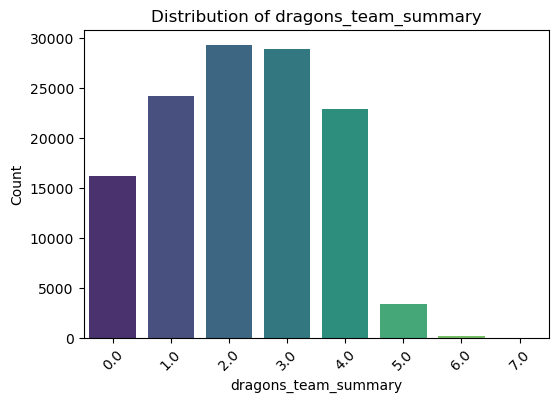

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')


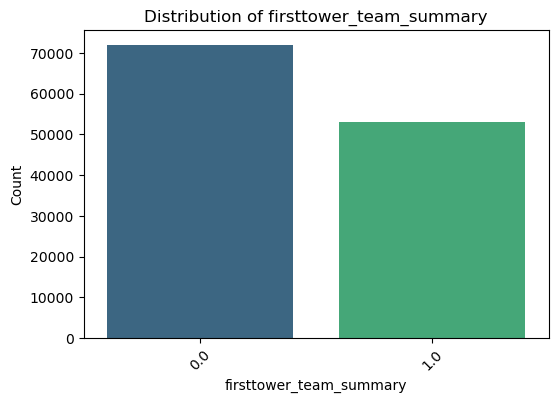

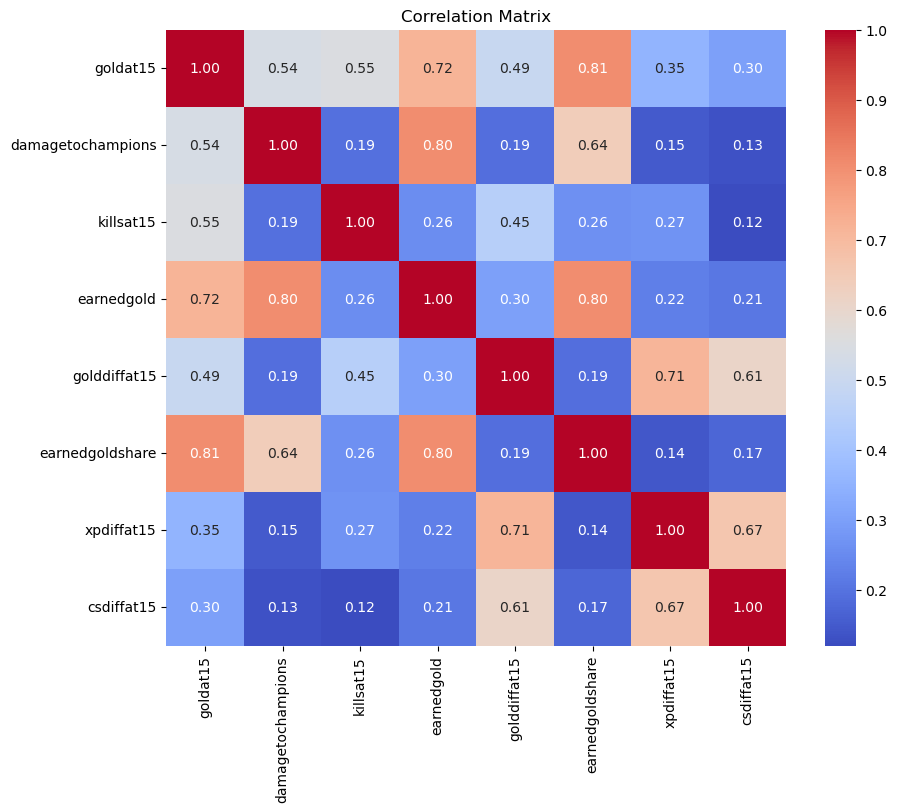

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


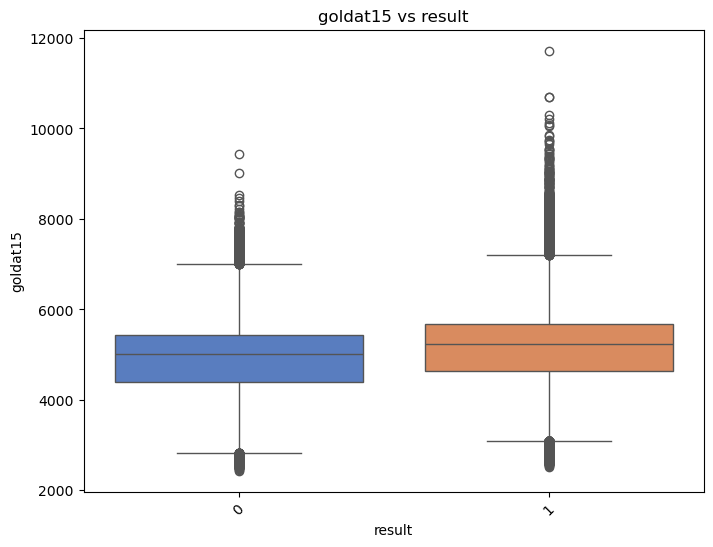

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


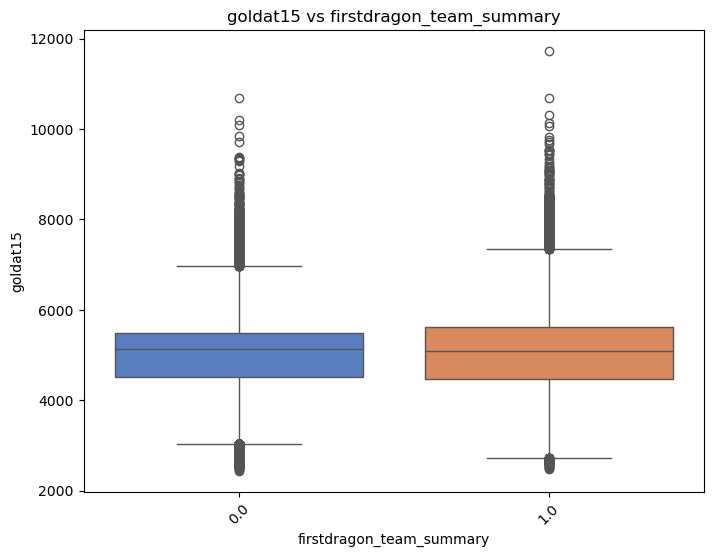

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


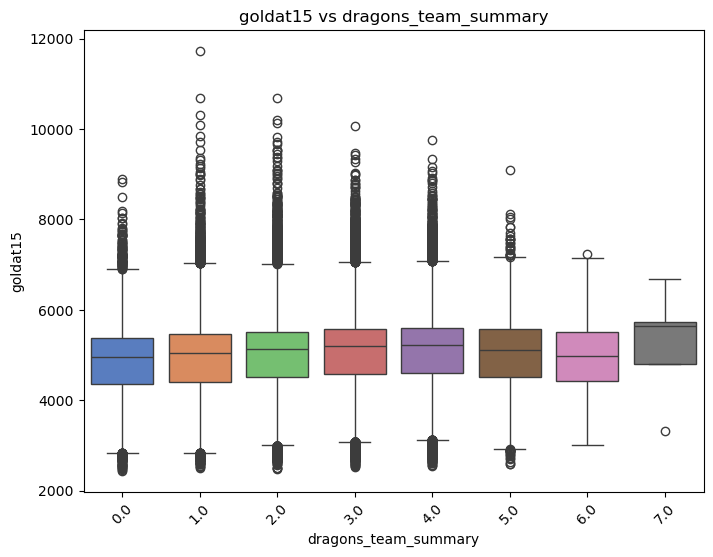

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


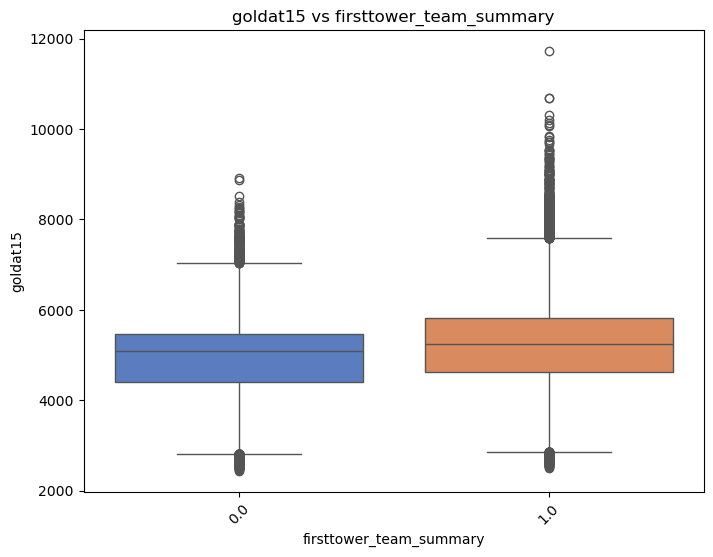

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


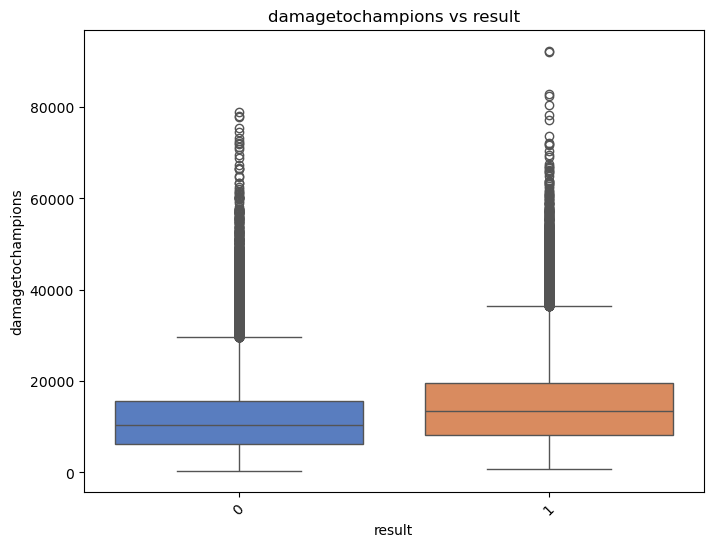

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


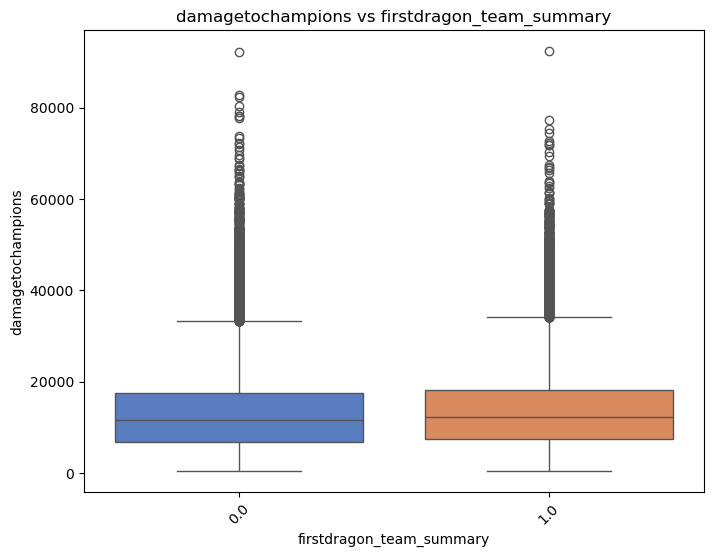

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


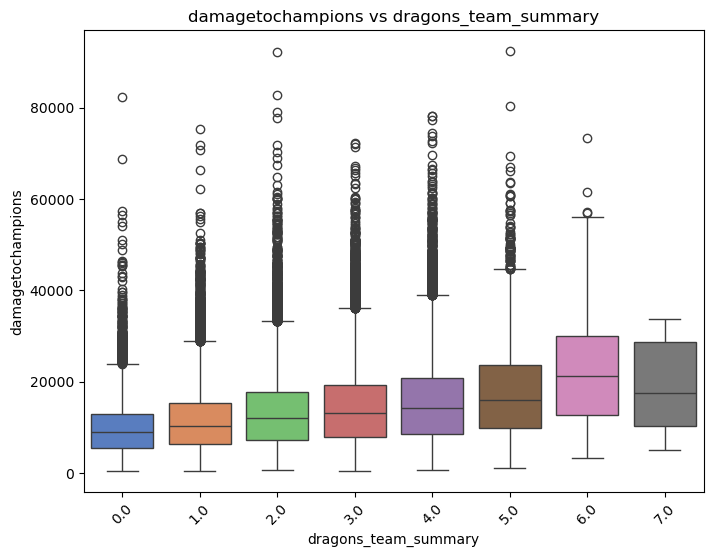

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


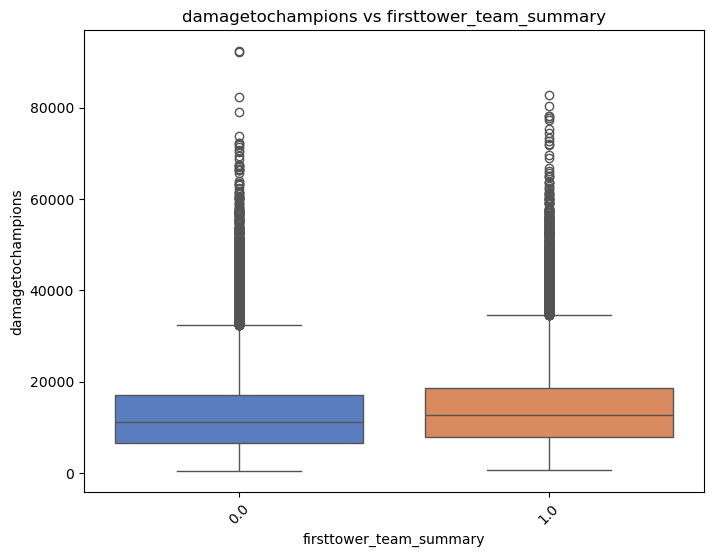

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


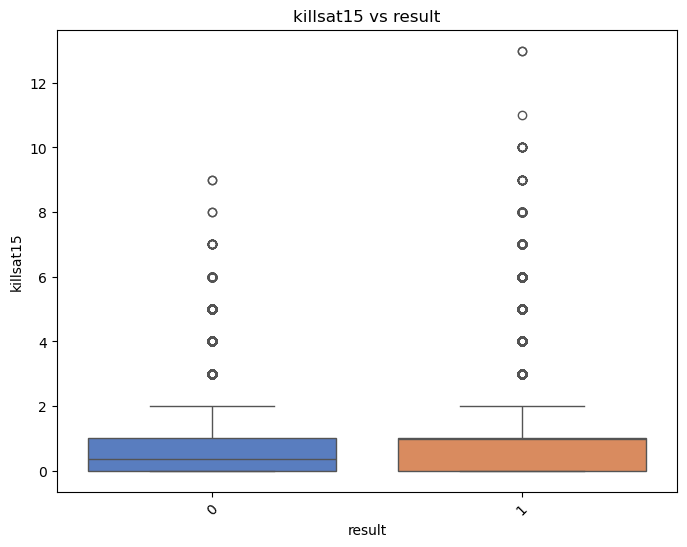

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


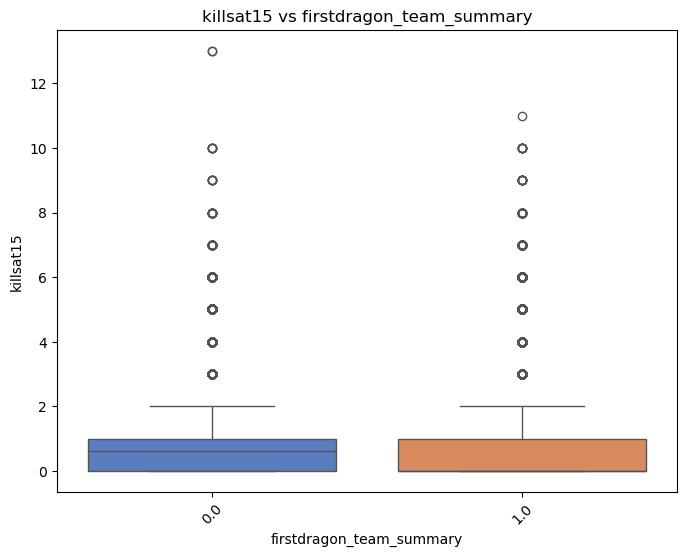

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


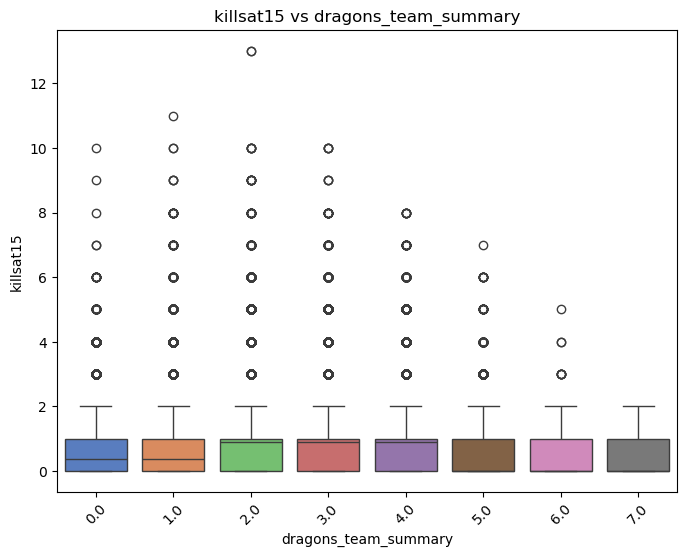

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


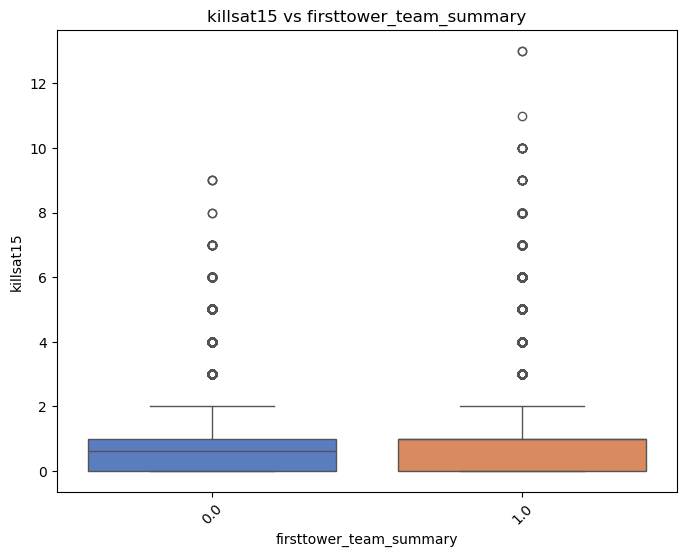

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


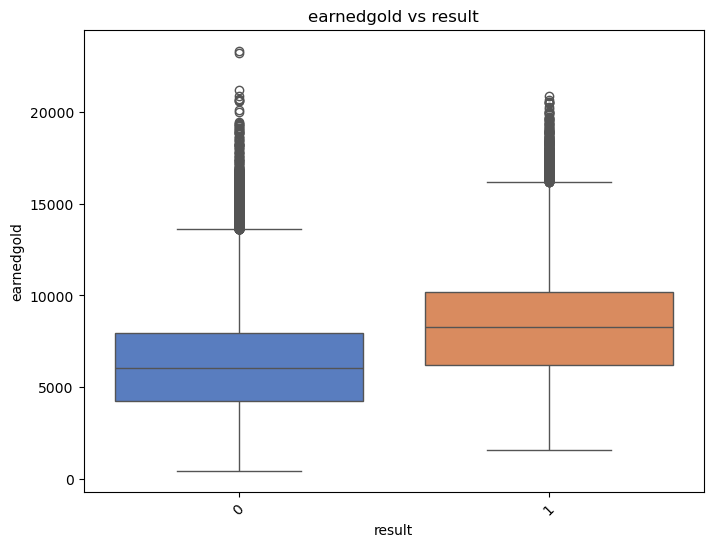

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


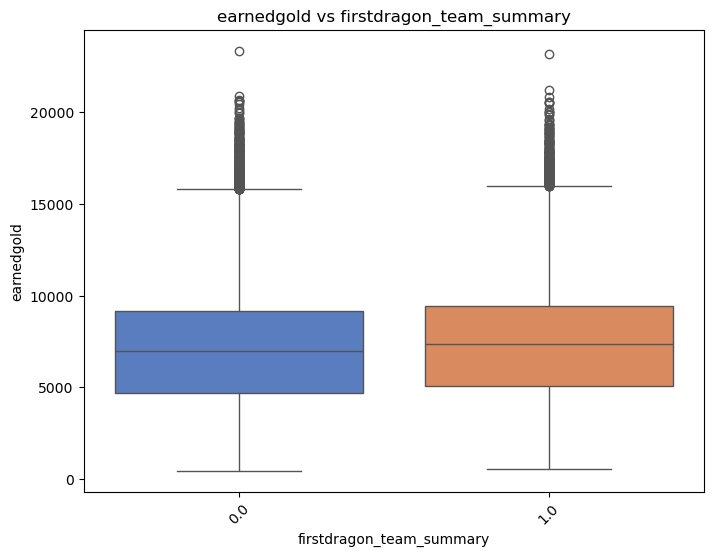

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


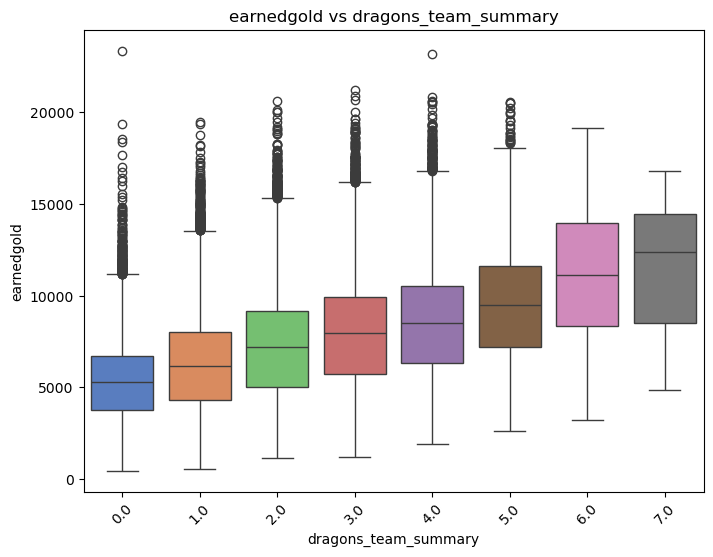

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


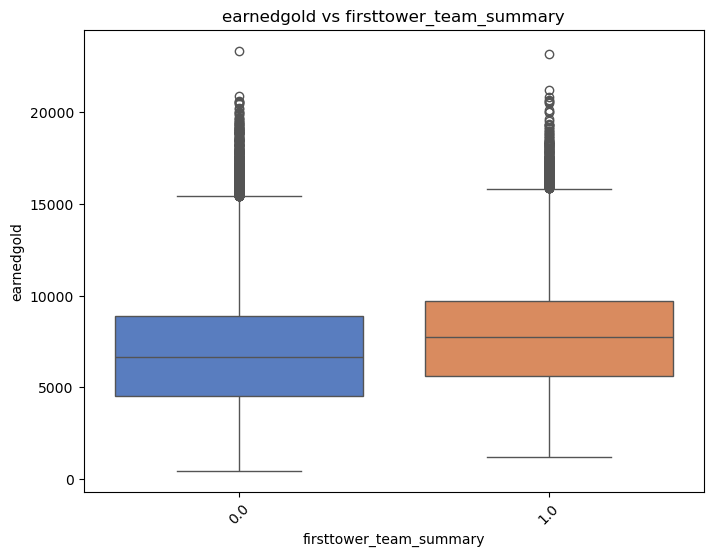

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


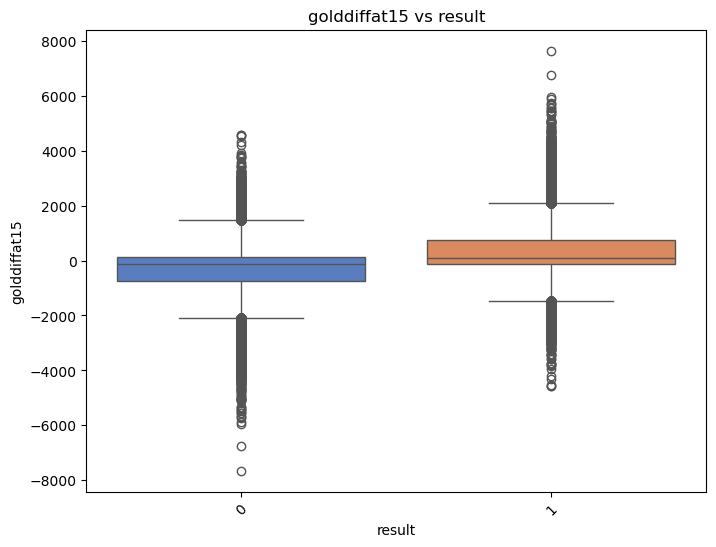

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


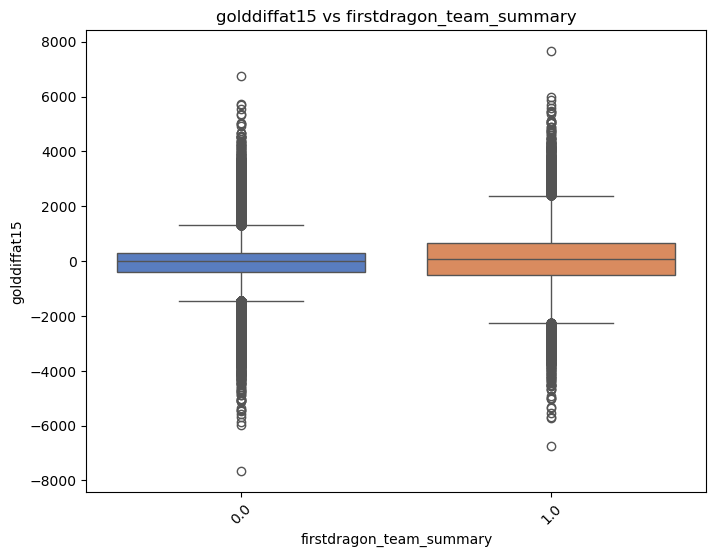

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


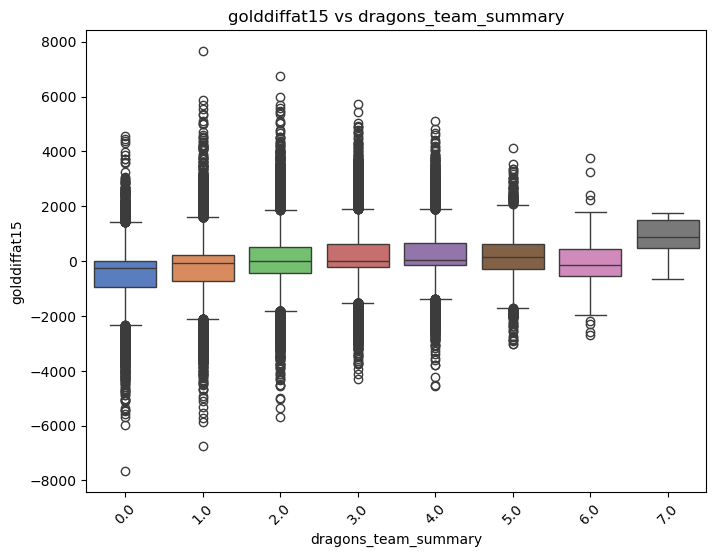

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


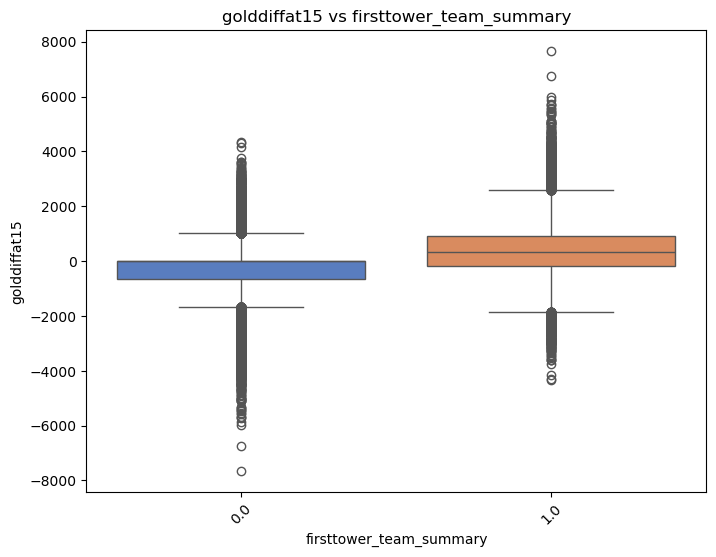

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


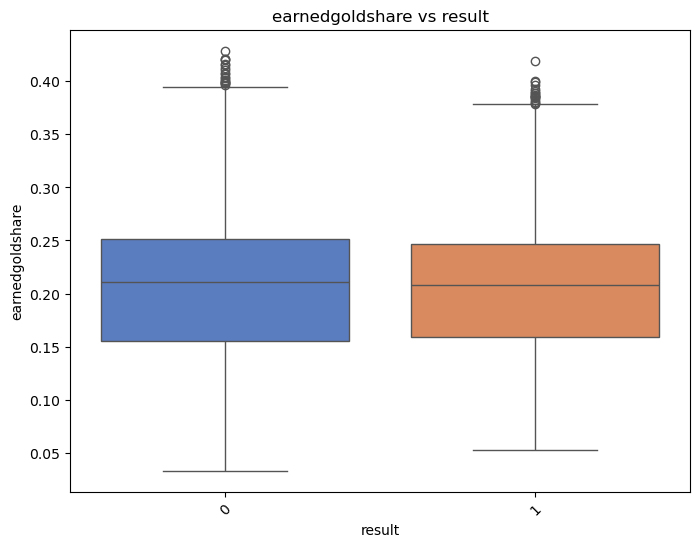

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


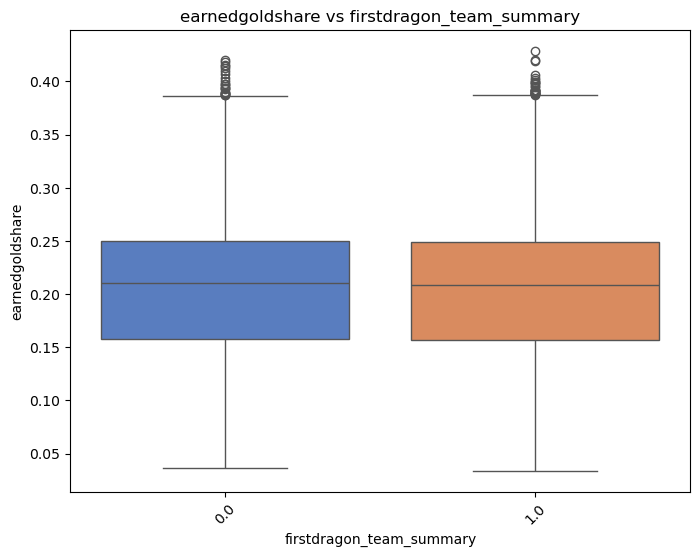

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


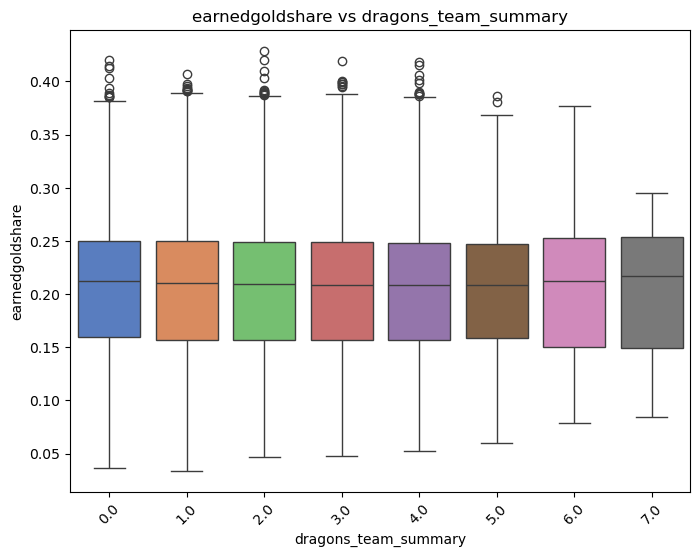

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


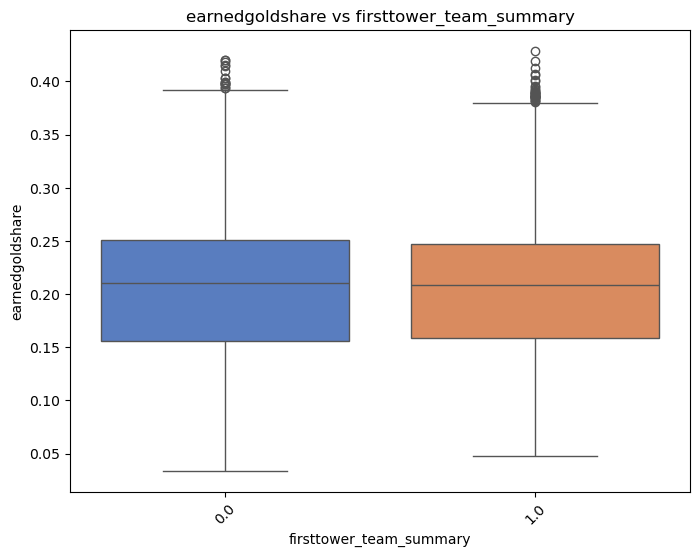

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


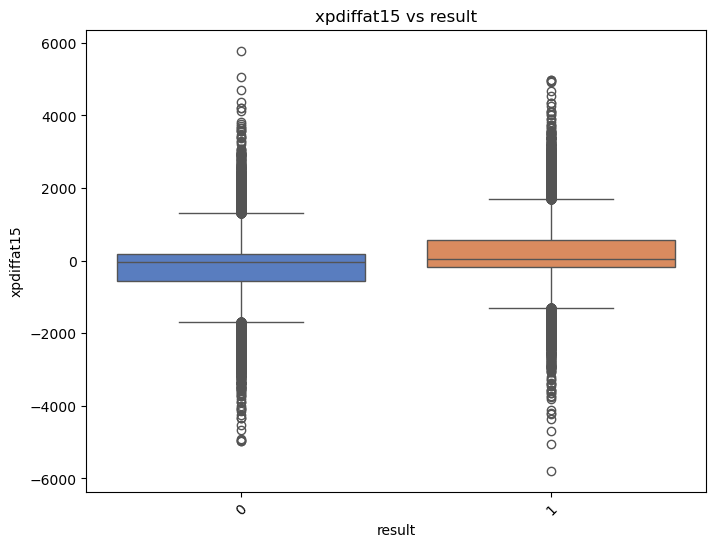

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


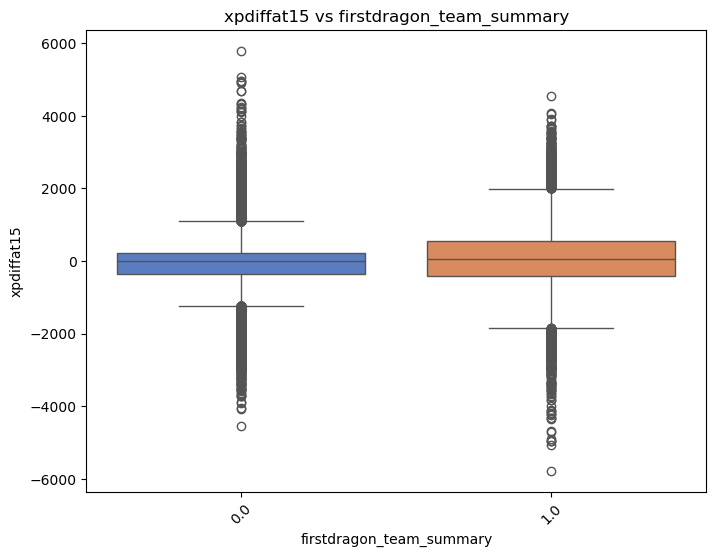

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


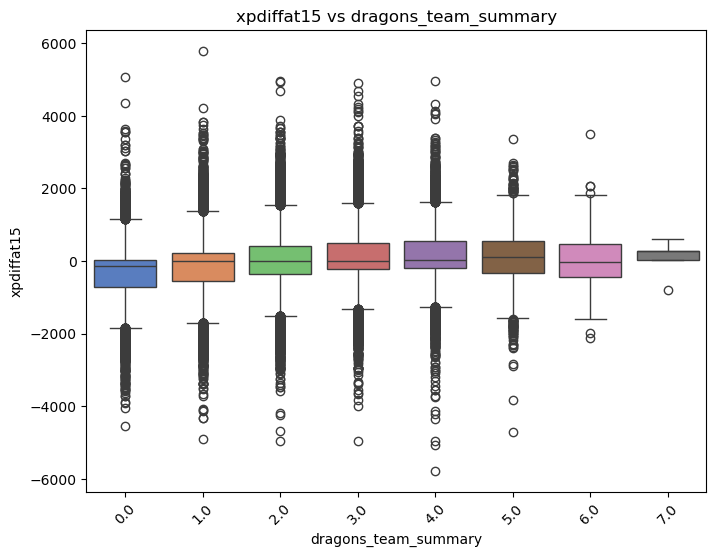

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


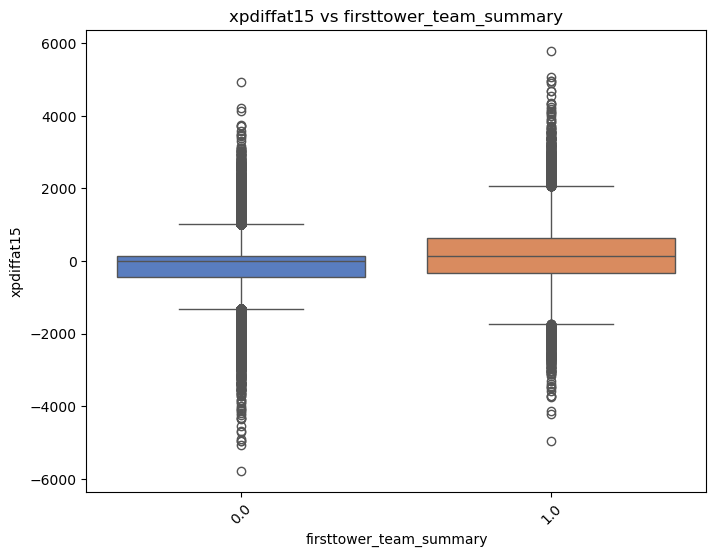

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


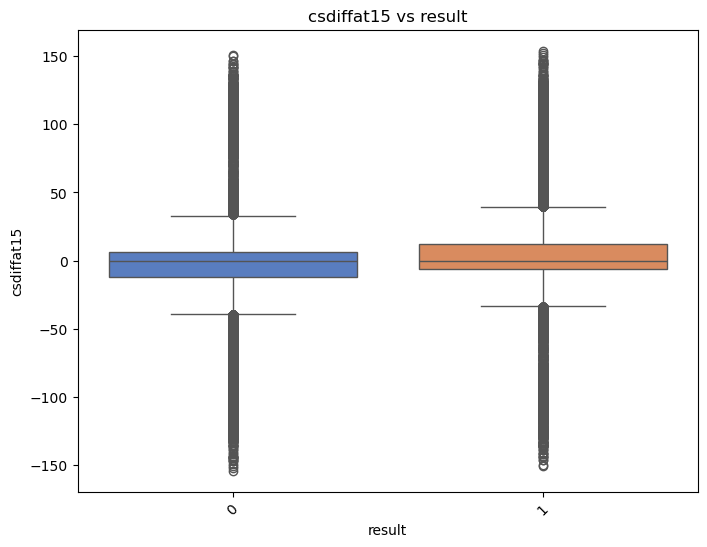

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


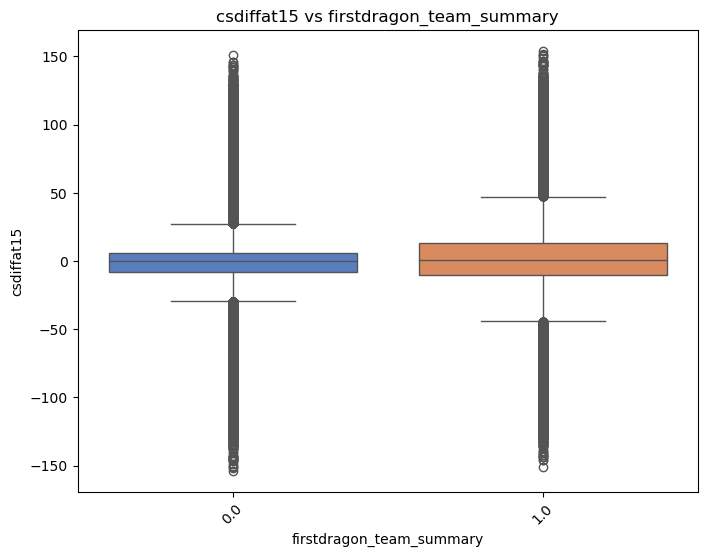

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


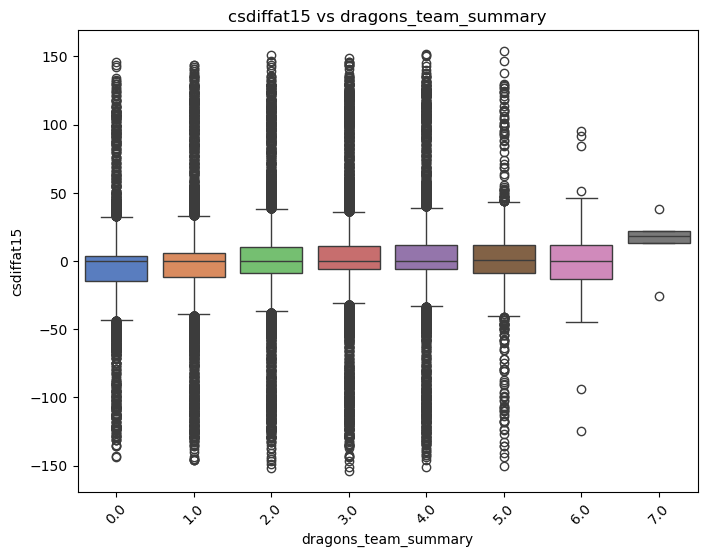

/var/folders/ps/cxk7gpds70390sk1wh4zjd240000gn/T/ipykernel_1285/2955066257.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')


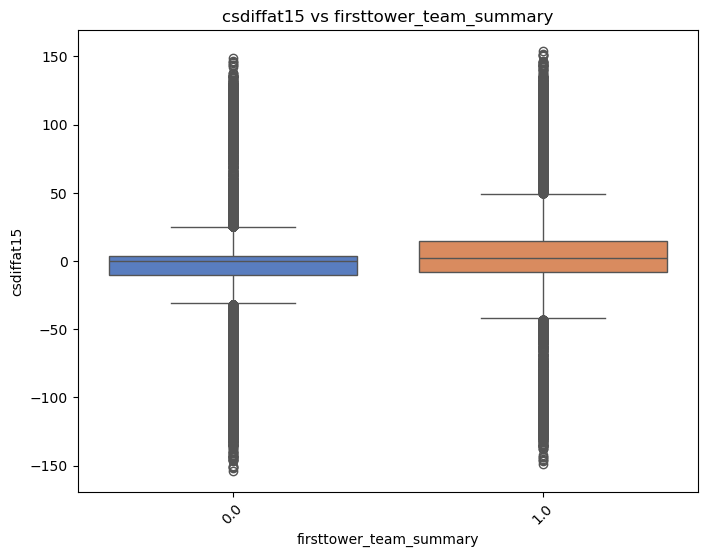

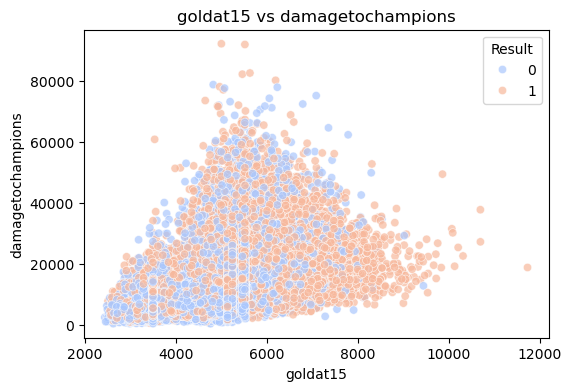

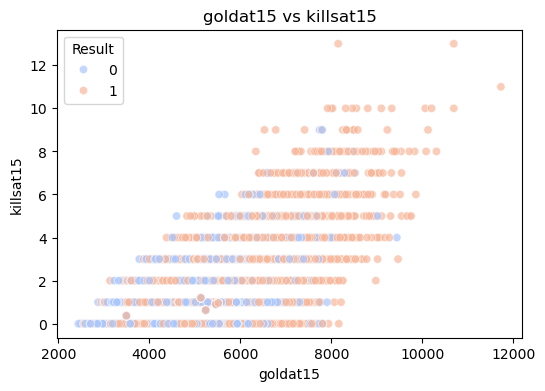

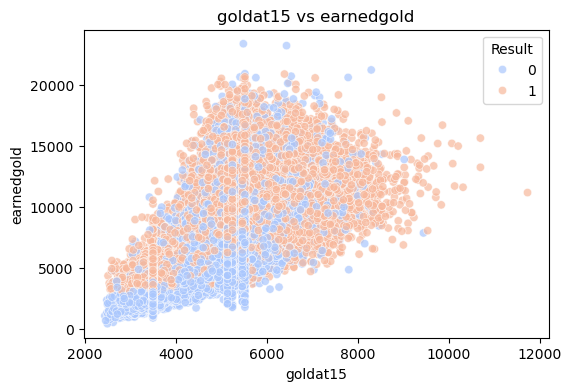

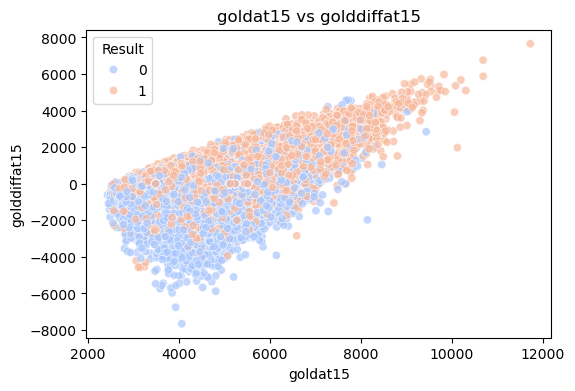

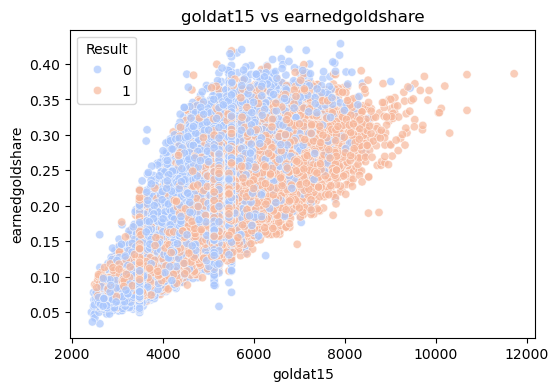

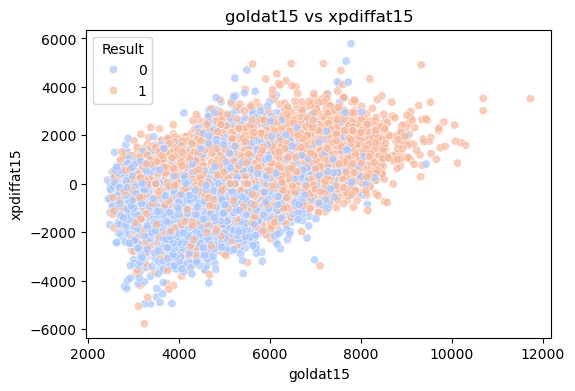

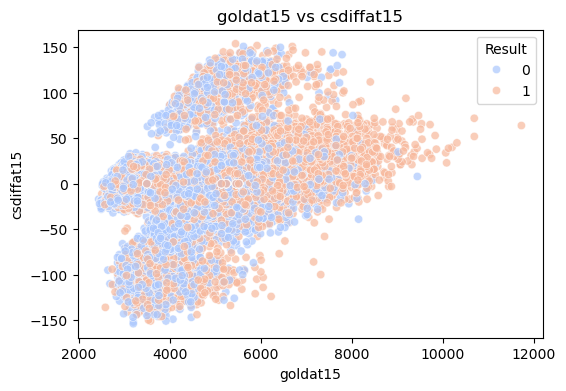

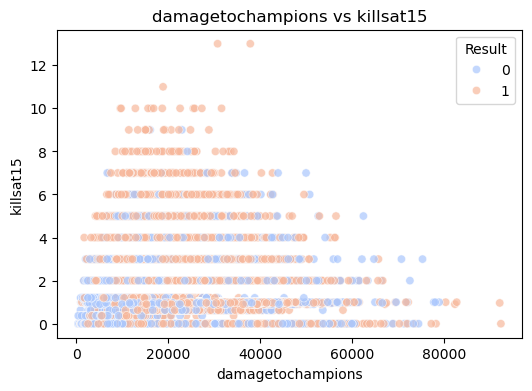

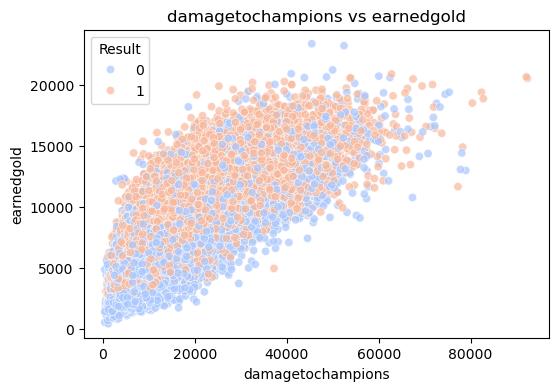

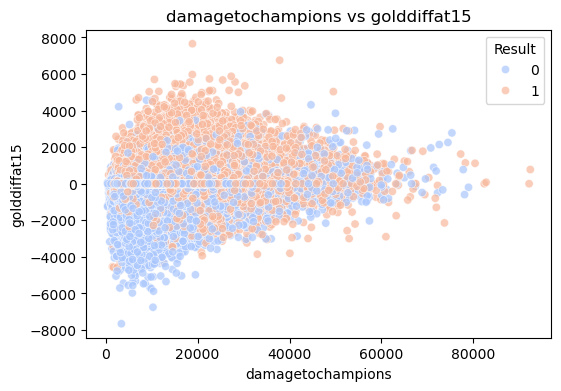

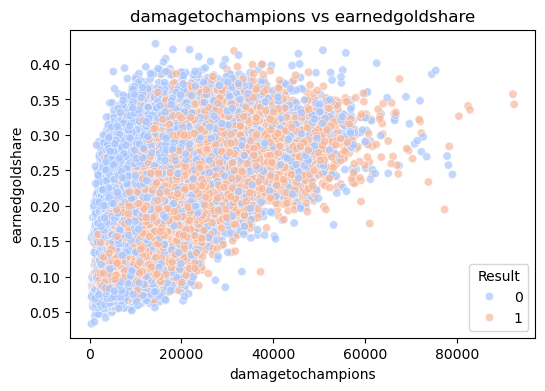

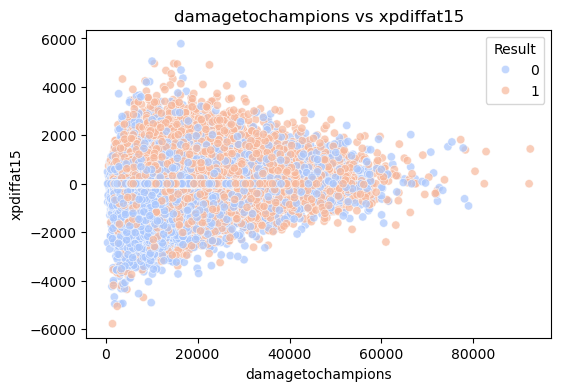

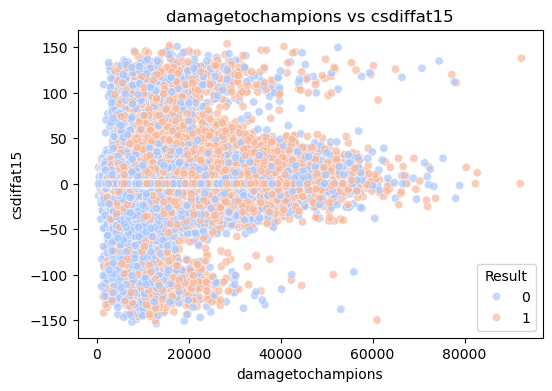

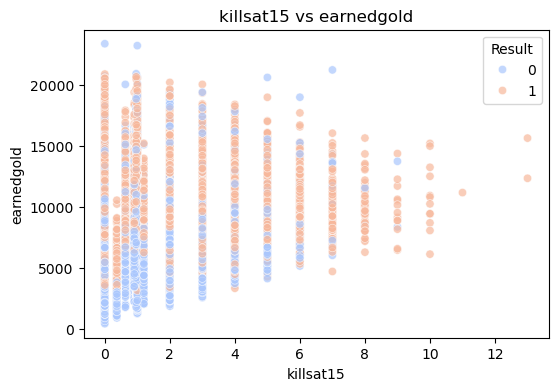

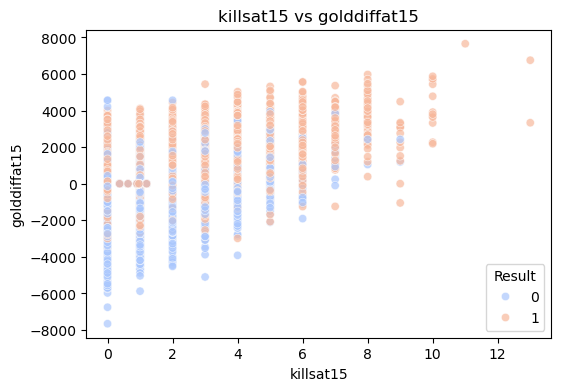

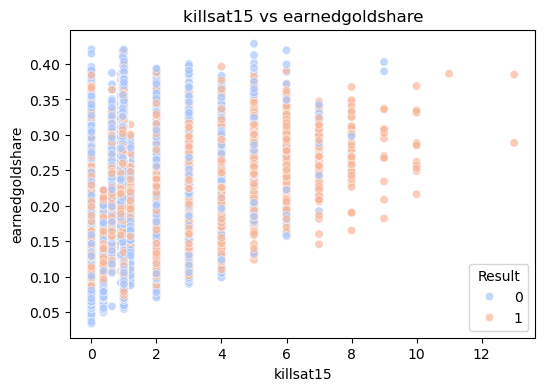

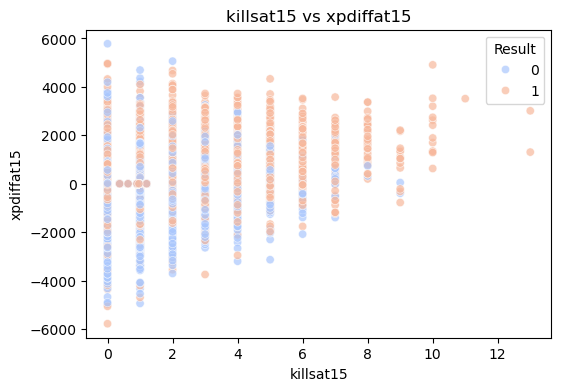

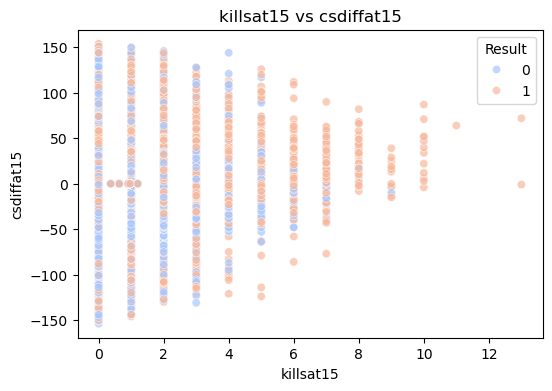

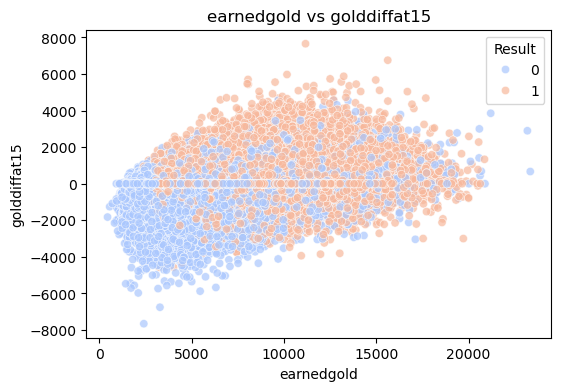

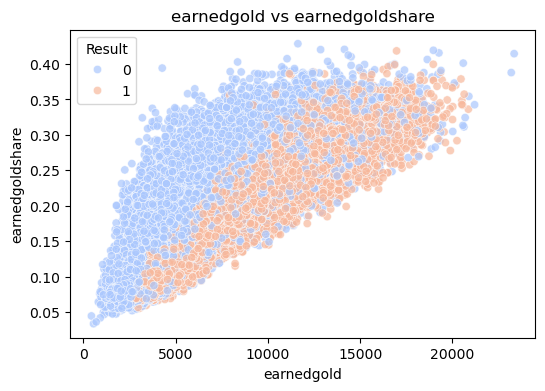

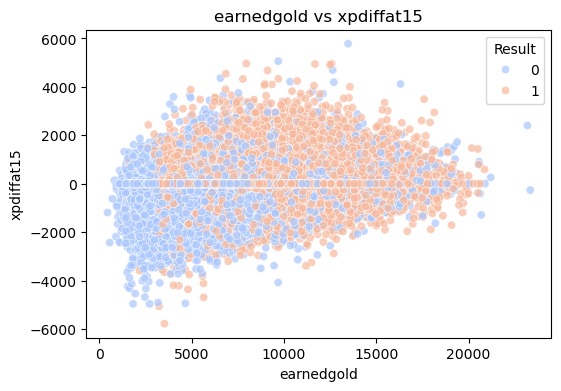

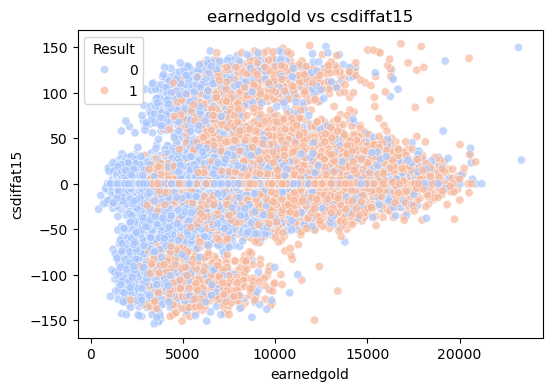

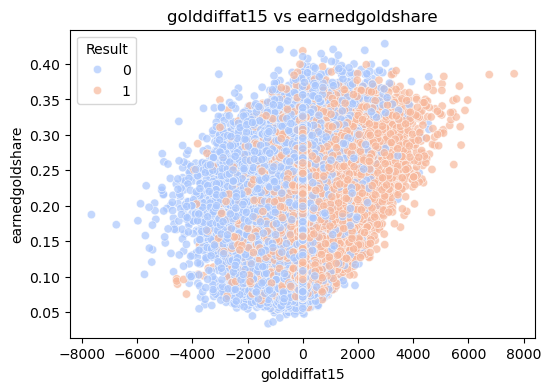

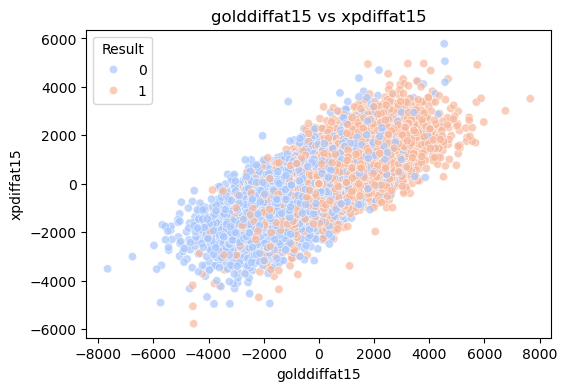

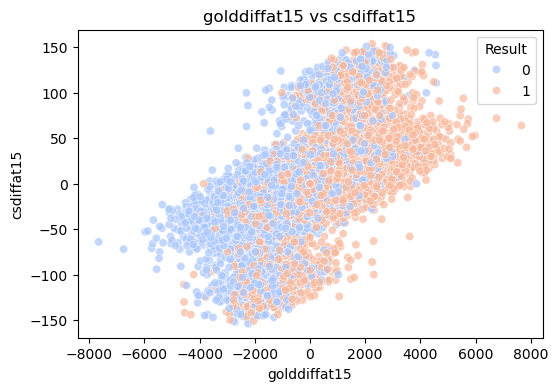

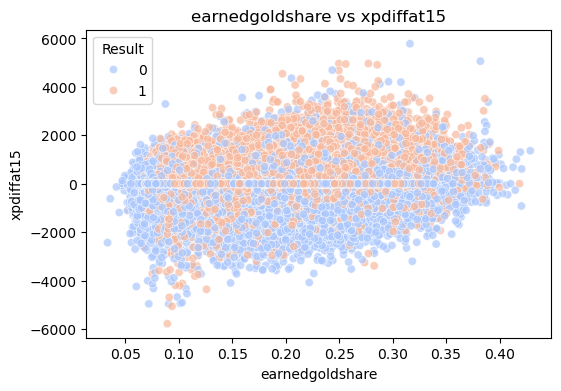

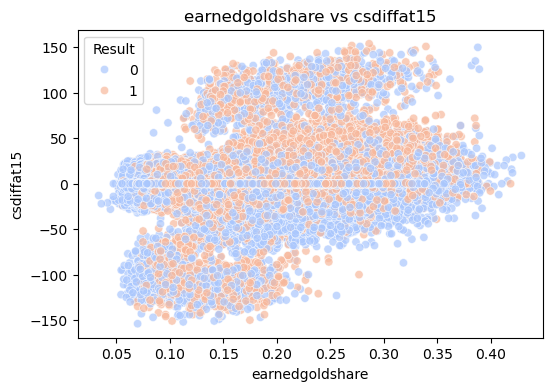

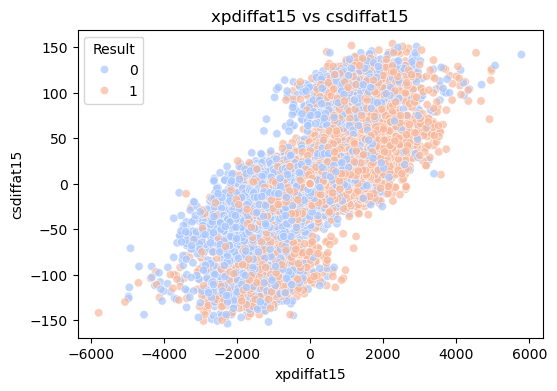

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define numerical and categorical columns
numerical_cols = ['goldat15', 'damagetochampions', 'killsat15', 'earnedgold', 
                  'golddiffat15', 'earnedgoldshare', 'xpdiffat15', 'csdiffat15']
categorical_cols = ['result', 'firstdragon_team_summary', 'dragons_team_summary', 'firsttower_team_summary']

# Univariate Analysis
def univariate_analysis(df, numerical_cols, categorical_cols):
    print(df[numerical_cols].describe())
    for col in categorical_cols:
        print(f"\nFrequency of {col}:")
        print(df[col].value_counts())
    for col in numerical_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col].dropna(), kde=True, bins=30, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    
    for col in categorical_cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, palette='viridis')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

def bivariate_analysis(df, numerical_cols, categorical_cols):
    # Correlation matrix for numerical columns
    correlation_matrix = df[numerical_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()
    
    # Box plots for numerical vs categorical columns
    for num_col in numerical_cols:
        for cat_col in categorical_cols:
            plt.figure(figsize=(8, 6))
            sns.boxplot(data=df, x=cat_col, y=num_col, palette='muted')
            plt.title(f'{num_col} vs {cat_col}')
            plt.xlabel(cat_col)
            plt.ylabel(num_col)
            plt.xticks(rotation=45)
            plt.show()
    
    # Scatter plots for numerical vs numerical columns
    for i, col1 in enumerate(numerical_cols):
        for col2 in numerical_cols[i + 1:]:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(data=df, x=col1, y=col2, hue='result', palette='coolwarm', alpha=0.7)
            plt.title(f'{col1} vs {col2}')
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.legend(title='Result', loc='best')
            plt.show()

# Perform Univariate and Bivariate Analysis
univariate_analysis(league_df, numerical_cols, categorical_cols)
bivariate_analysis(league_df, numerical_cols, categorical_cols)


In [137]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Define numerical and categorical columns
numerical_cols = ['goldat15', 'damagetochampions', 'killsat15', 'earnedgold',
                  'golddiffat15', 'earnedgoldshare', 'xpdiffat15', 'csdiffat15']
categorical_cols = ['result', 'firstdragon_team_summary', 'dragons_team_summary', 'firsttower_team_summary']

# Univariate Analysis
# Summary statistics for numerical columns
print(league_df[numerical_cols].describe())

# Frequency counts for categorical columns
for col in categorical_cols:
    print(f"\nFrequency of {col}:")
    print(league_df[col].value_counts())

# Distribution plots for numerical columns
for col in numerical_cols:
    fig = px.histogram(league_df, x=col, nbins=30, marginal="box", title=f"Distribution of {col}")
    fig.update_layout(xaxis_title=col, yaxis_title="Frequency")
    fig.write_html(f"plots/distribution_{col}.html", include_plotlyjs='cdn')
    fig.show()

# Count plots for categorical columns
for col in categorical_cols:
    fig = px.histogram(league_df, x=col, color=col, title=f"Distribution of {col}", color_discrete_sequence=px.colors.qualitative.Vivid)
    fig.update_layout(xaxis_title=col, yaxis_title="Count", xaxis={'categoryorder': 'total descending'})
    fig.write_html(f"plots/distribution_{col}.html", include_plotlyjs='cdn')
    fig.show()

# Bivariate Analysis
# Correlation matrix for numerical columns
correlation_matrix = league_df[numerical_cols].corr()
fig = go.Figure(data=go.Heatmap(z=correlation_matrix.values,
                                x=correlation_matrix.columns,
                                y=correlation_matrix.columns,
                                colorscale='coolwarm',
                                zmin=-1, zmax=1))
fig.update_layout(title="Correlation Matrix", xaxis_title="", yaxis_title="")
fig.write_html("plots/correlation_matrix.html", include_plotlyjs='cdn')
fig.show()

# Box plots for numerical vs categorical columns
for num_col in numerical_cols:
    for cat_col in categorical_cols:
        fig = px.box(league_df, x=cat_col, y=num_col, color=cat_col,
                     title=f"{num_col} vs {cat_col}", color_discrete_sequence=px.colors.qualitative.Set2)
        fig.update_layout(xaxis_title=cat_col, yaxis_title=num_col, xaxis_tickangle=45)
        fig.write_html(f"plots/{num_col}_vs_{cat_col}.html", include_plotlyjs='cdn')
        fig.show()

# Scatter plots for numerical vs numerical columns
for i, col1 in enumerate(numerical_cols):
    for col2 in numerical_cols[i + 1:]:
        fig = px.scatter(league_df, x=col1, y=col2, color='result',
                         title=f"{col1} vs {col2}", color_discrete_sequence=px.colors.qualitative.Prism)
        fig.update_layout(xaxis_title=col1, yaxis_title=col2)
        fig.write_html(f"plots/{col1}_vs_{col2}.html", include_plotlyjs='cdn')
        fig.show()


            goldat15  damagetochampions      killsat15     earnedgold  \
count  125120.000000      125120.000000  125120.000000  125120.000000   
mean     4965.336076       13339.074624       0.814865    7243.567711   
std       960.718266        8319.966666       1.040773    3063.194627   
min      2433.000000         403.000000       0.000000     439.000000   
25%      4486.000000        7050.000000       0.000000    4855.000000   
50%      5130.463237       11809.000000       0.631049    7145.000000   
75%      5511.964461       17697.000000       1.000000    9281.000000   
max     11723.000000       92366.000000      13.000000   23345.000000   

        golddiffat15  earnedgoldshare     xpdiffat15     csdiffat15  
count  125120.000000    125120.000000  125120.000000  125120.000000  
mean        0.000000         0.200000       0.000000       0.000000  
std       949.077077         0.068002     731.858183      22.590886  
min     -7659.000000         0.033543   -5783.000000    -154.0

FileNotFoundError: [Errno 2] No such file or directory: 'plots/distribution_goldat15.html'

In [104]:
grouped_stats = league_df.groupby(['result', 'position'])[[
    'goldat15', 'damagetochampions', 'killsat15', 'golddiffat15'
]].mean().reset_index()

pivot_table = pd.pivot_table(
    league_df,
    values=['goldat15', 'killsat15', 'golddiffat15'],
    index='position',
    columns='result',
    aggfunc='mean'
)
pivot_table




goldat15              golddiffat15             killsat15  \
result              0            1            0           1         0   
position                                                                
bot       5307.950034  5715.978887  -408.028852  408.028852  0.767394   
jng       4985.381275  5275.545198  -290.163923  290.163923  1.014166   
mid       5304.766245  5606.789583  -302.023338  302.023338  0.736410   
sup       3398.915177  3585.337412  -186.422235  186.422235  0.314975   
top       5096.710567  5375.986382  -279.275815  279.275815  0.521953   

                    
result           1  
position            
bot       1.162375  
jng       1.388207  
mid       1.076243  
sup       0.426788  
top       0.740144

## Step 3: Assessment of Missingness

In [116]:
league_df.isna().mean().sort_values(ascending=False)

firsttower           0.858532
firstdragon          0.858532
firstdragon          0.858532
dragons              0.833333
earnedgoldshare      0.166667
goldat15             0.151191
csdiffat15           0.151191
killsat15            0.151191
xpdiffat15           0.151191
killsat15            0.151191
goldat15             0.151191
golddiffat15         0.151191
earnedgold           0.000093
damagetochampions    0.000080
result               0.000000
league               0.000000
gameid               0.000000
dtype: float64

In [123]:
cols = ['firsttower', 
    'firstdragon', 
    'dragons', 
    'earnedgoldshare', 
    'csdiffat15', 
    'killsat15', 
    'xpdiffat15', 
    'goldat15',  # Duplicate entry
    'golddiffat15']

cols22 = ['firsttower', 
         
         '''
    'firstdragon', 
    'dragons', 
    'earnedgoldshare', 
    'csdiffat15', 
    'killsat15', 
    'xpdiffat15', 
    'goldat15',  # Duplicate entry
    'golddiffat15'
    '''
    ]

fcols = list(set(cols))  # Remove duplicates

# Add missingness columns to dataframe once
mcar = league_df[cols].copy()
for col in cols:
    mcar[f'{col}_missing'] = mcar[col].isna()

n_repetitions = 500
tvds_results = {}

# Loop through columns and calculate TVD for missingness
for col1 in cols22:
    tvds = []
    for col2 in cols:
        if col1 == col2:
            continue

        shuffled = mcar.copy()
        for _ in range(n_repetitions):
            shuffled[col2] = np.random.permutation(shuffled[col2])

            # Pivot table to calculate missingness distribution
            pivoted = shuffled.pivot_table(index=col2, columns=f'{col1}_missing', aggfunc='size')
            pivoted = pivoted / pivoted.sum()

            # Calculate TVD
            tvd = (pivoted[True] - pivoted[False]).abs().sum() / 2
            tvds.append(tvd)

        # Store the mean TVD for this pair of columns
        tvds_results[(col1, col2)] = np.mean(tvds)

# tvds_results contains the mean TVD for each pair of columns


KeyError: "\n    'firstdragon', \n    'dragons', \n    'earnedgoldshare', \n    'csdiffat15', \n    'killsat15', \n    'xpdiffat15', \n    'goldat15',  # Duplicate entry\n    'golddiffat15'\n    _missing"

In [111]:
league_df.isna().mean()
mcar = league_df.copy()
mcar['child_missing'] = heights_mcar['child'].isna()
n_repetitions = 500
shuffled = heights_mcar.copy()

tvds = []
for _ in range(n_repetitions):
    
    # Shuffling genders. 
    # Note that we are assigning back to the same DataFrame for performance reasons; 
    # see https://dsc80.com/resources/lectures/lec07/lec07-fast-permutation-tests.html.
    shuffled['gender'] = np.random.permutation(shuffled['gender'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled
        .pivot_table(index='gender', columns='child_missing', aggfunc='size')
    )
    
    pivoted = pivoted / pivoted.sum()
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd

gameid               0.000000
result               0.000000
league               0.000000
goldat15             0.151191
firstdragon          0.858532
damagetochampions    0.000080
killsat15            0.151191
firstdragon          0.858532
earnedgold           0.000093
killsat15            0.151191
goldat15             0.151191
golddiffat15         0.151191
earnedgoldshare      0.166667
xpdiffat15           0.151191
csdiffat15           0.151191
dragons              0.833333
firsttower           0.858532
dtype: float64

In [109]:
def permutation_test_missingness(df, missing_column, dependency_column, n_permutations=10000):
    # Create missingness indicator
    missingness = df[missing_column].isnull()
    
    # Original difference in means
    original_diff = df.loc[~missingness, dependency_column].mean() - \
                    df.loc[missingness, dependency_column].mean()
    
    # Combine values for permutation
    combined_values = df[dependency_column].dropna()
    
    # Permutation test
    permuted_diffs = []
    for _ in range(n_permutations):
        # Randomly sample to match original group sizes
        permuted_sample = np.random.permutation(combined_values)
        permuted_group1 = permuted_sample[:sum(~missingness)]
        permuted_group2 = permuted_sample[sum(~missingness):]
        
        # Compute difference in means
        permuted_diff = permuted_group1.mean() - permuted_group2.mean()
        permuted_diffs.append(permuted_diff)
    
    # Calculate p-value (two-sided test)
    p_value = np.mean([np.abs(diff) >= np.abs(original_diff) for diff in permuted_diffs])
    
    return {
        'original_diff': original_diff,
        'p_value': p_value
    }
       


columns_to_test = ['dragons',
    'earnedgoldshare',
    'goldat15',
    'csdiffat15',
    'killsat15',
    'xpdiffat15',
    'killsat15',
    'goldat15',
    'golddiffat15',
    'earnedgold']

missing_column = 'firstdragon'
results = {}
for column in columns_to_test:
    results[column] = permutation_test_missingness(df, missing_column, column)

KeyboardInterrupt: 

In [142]:
# TODO

## Step 4: Hypothesis Testing
Null Hypothesis (H0):

The distribution of gold at 15 is the same for winning and losing matches meaning that there is no statistically significant difference in gold after 15 minutes between wins and losses

Alternative Hypothesis (H1):

There is a statistically significant difference in the distribution of gold at 15 between winning and losing matches meaning that the gold after 15 minutes values differ between wins and losses in a way that cannot be explained by random chance

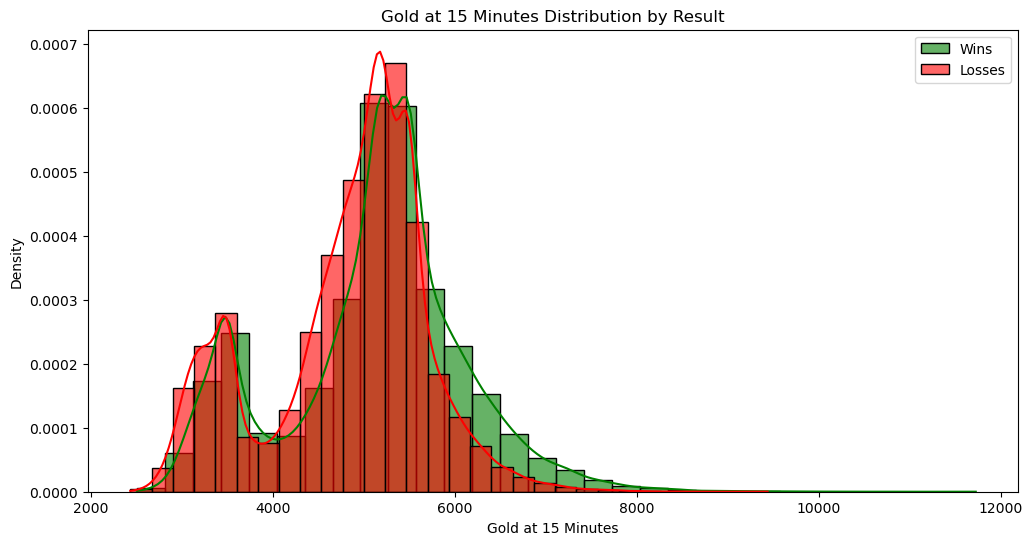

In [143]:
test_df = league_df[['result', 'goldat15']]
win_df = test_df[test_df['result'] == 1]
loss_df = test_df[test_df['result'] == 0]

import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions
plt.figure(figsize=(12, 6))
sns.histplot(win_df['goldat15'], color='green', label='Wins', kde=True, stat="density", bins=30, alpha=0.6)
sns.histplot(loss_df['goldat15'], color='red', label='Losses', kde=True, stat="density", bins=30, alpha=0.6)
plt.title('Gold at 15 Minutes Distribution by Result')
plt.xlabel('Gold at 15 Minutes')
plt.ylabel('Density')
plt.legend()
plt.show()

# as we can see here they have similar sort of shapes but the wins is a bit more skewed -> maybe compute differnece of means for a permutation test to see if they belong to the same population?


In [145]:
# Permutations Test
import numpy as np
observed_diff = win_df['goldat15'].mean() - loss_df['goldat15'].mean()
combined = test_df['goldat15'].values
n_permutations = 10000
diffs = []
for _ in range(n_permutations):
    np.random.shuffle(combined)
    perm_win = combined[:len(win_df)]
    perm_loss = combined[len(win_df):]
    diffs.append(perm_win.mean() - perm_loss.mean())
p_value = np.mean(np.abs(diffs) >= np.abs(observed_diff))
observed_diff, p_value

# We reject the null as the p-value because it is less than 0.05 which means the difference is statistically significant

(np.float64(293.18283248081843), np.float64(0.0))

## Step 5: Framing a Prediction Problem


For my predicition problem - I want to consider several individual and economic factors that could possibly be used to predict whether or not an individual will win or lose a match in Summoner's Rift. Specifically, I plan to use a Logisitc Regression model and the response variable in mind is the results column which would make it a binary classification task(i.e predicting a win(1) or a loss(0)) 


- Need to justify?

In [ ]:
# 

## Step 6: Baseline Model

In [12]:
mdl_df

result position league     goldat15  firstdragon_team_summary  \
0            0      top   LCKC  5025.000000                       0.0   
1            0      jng   LCKC  5366.000000                       0.0   
2            0      mid   LCKC  5118.000000                       0.0   
3            0      bot   LCKC  5461.000000                       0.0   
4            0      sup   LCKC  3836.000000                       0.0   
...        ...      ...    ...          ...                       ...   
150161       1      top   DCup  5236.348475                       0.0   
150162       1      jng   DCup  5130.463237                       0.0   
150163       1      mid   DCup  5455.777914                       0.0   
150164       1      bot   DCup  5511.964461                       0.0   
150165       1      sup   DCup  3492.126294                       0.0   

        damagetochampions  killsat15  earnedgold  golddiffat15  \
0                 15768.0   0.000000      7164.0         391.0   
1                 11765.0   2.000000      5368.0         541.0   
2                 14258.0   0.000000      5945.0        -475.0   
3                 11106.0   2.000000      6835.0        -793.0   
4                  3663.0   1.000000      2908.0         443.0   
...                   ...        ...         ...           ...   
150161            13352.0   0.631049      9832.0           0.0   
150162             5979.0   1.201186      6271.0           0.0   
150163            19185.0   0.906326      8667.0           0.0   
150164            28282.0   0.964884     10416.0           0.0   
150165            10950.0   0.370881      4811.0           0.0   

        earnedgoldshare  xpdiffat15  csdiffat15  dragons_team_summary  \
0              0.253859       345.0        14.0                   1.0   
1              0.190220      -275.0       -11.0                   1.0   
2              0.210665       153.0         1.0                   1.0   
3              0.242201     -1343.0       -34.0                   1.0   
4              0.103054      -497.0         7.0                   1.0   
...                 ...         ...         ...                   ...   
150161         0.245817         0.0         0.0                   4.0   
150162         0.156788         0.0         0.0                   4.0   
150163         0.216691         0.0         0.0                   4.0   
150164         0.260417         0.0         0.0                   4.0   
150165         0.120287         0.0         0.0                   4.0   

        firsttower_team_summary  
0                           1.0  
1                           1.0  
2                           1.0  
3                           1.0  
4                           1.0  
...                         ...  
150161                      0.0  
150162                      0.0  
150163                      0.0  
150164                      0.0  
150165                      0.0  

[125120 rows x 14 columns]

In [47]:
mdl_df = league_df.drop(columns=['gameid'])
mdl_df['position'].value_counts()
X = mdl_df.drop('result', axis=1)
y = mdl_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
)

def create_logistic_regression_pipeline(df):
    numeric_features = [
        'goldat15', 'killsat15', 'golddiffat15', 'earnedgoldshare', 
        'xpdiffat15', 'csdiffat15'
    ]
    categorical_features = [
        'firstdragon_team_summary', 
        'dragons_team_summary', 'firsttower_team_summary',
        'position', 'league'
    ]

    preproc = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preproc),
        ('classifier', LogisticRegression(
            max_iter=1000,  # Increased iterations to ensure convergence
            random_state=42,
            penalty='l2',  # L2 regularization (Ridge)
            C=1.0  # Inverse of regularization strength
        ))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return pipeline
create_logistic_regression_pipeline(mdl_df)
    

Accuracy Score: 0.7913203324808185

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     12442
           1       0.78      0.81      0.80     12582

    accuracy                           0.79     25024
   macro avg       0.79      0.79      0.79     25024
weighted avg       0.79      0.79      0.79     25024


Confusion Matrix:
[[ 9652  2790]
 [ 2432 10150]]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['goldat15', 'killsat15',
                                                   'golddiffat15',
                                                   'earnedgoldshare',
                                                   'xpdiffat15',
                                                   'csdiffat15']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['firstdragon_team_summary',
                                                   'dragons_team_summary',
                                                   'firsttower_team_summary',
                                                   'position', 'league'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

## Step 7: Final Model

In [70]:
league_df['league'].unique()

array(['LCKC', 'LPL', 'NLC', 'LVP SL', 'PGC', 'UL', 'PRM', 'LCK', 'LFL',
       'LEC', 'LCS', 'LFL2', 'GLL', 'HM', 'ESLOL', 'EBL', 'LPLOL', 'PGN',
       'LCSA', 'DDH', 'TAL', 'TCL', 'CBLOL', 'LCO', 'LHE', 'GL', 'EL',
       'CBLOLA', 'LMF', 'VL', 'SL (LATAM)', 'LLA', 'HC', 'LDL', 'LJL',
       'PCS', 'VCS', 'UPL', 'LCL', 'NEXO', 'EUM', 'LAS', 'MSI', 'LJLA',
       'CT', 'WLDs', 'ASCI', 'CDF', 'IC', 'DCup'], dtype=object)

In [71]:
import numpy as np
import pandas as pd

def create_league_relative_features(df):
    # List of economic and performance features to analyze
    econ_features = [
        'goldat15', 
        'earnedgold', 
        'damagetochampions', 
        'killsat15', 
        'earnedgoldshare', 
        'golddiffat15', 
        'xpdiffat15', 
        'csdiffat15'
    ]
    
    # Create league-specific z-scores
    for feature in econ_features:
        # League-specific z-score
        df[f'{feature}_league_zscore'] = df.groupby('league')[feature].transform(
            lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
        )

        
        # League-specific percentile rank
        df[f'{feature}_league_percentile'] = df.groupby('league')[feature].transform(
            lambda x: x.rank(pct=True)
        )
    
    # Create interaction features
    df['goldat15_killsat15_interaction'] = df['goldat15'] * df['killsat15']
    df['earnedgold_xpdiff_interaction'] = df['earnedgold'] * df['xpdiffat15']
    
    # Create league region features 
    region_categories = {
    'LCK': 1, 'LPL': 1, 'LEC': 1, 'LCS': 1, 'LLA': 1, 'PCS': 1, 'VCS': 1, 'LCL': 1, 'TCL': 1, 'CBLOL': 1, 
    'LDL': 2, 'NLC': 2, 'LFL': 2, 'LFL2': 2, 'EBL': 2, 'ESLOL': 2, 'UL': 2, 'PRM': 2, 'UPL': 2, 'LCO': 2, 'LCSA': 2,  
    'LVP SL': 3, 'LCKC': 3, 'HM': 3, 'GL': 3, 'EL': 3, 'LHE': 3, 'LMF': 3, 'VL': 3, 'SL': 3, 'LJL': 3, 'LJLA': 3,  
    'PGC': 4, 'PGN': 4, 'NEXO': 4, 'EUM': 4, 'MSI': 4, 'WLDs': 4, 'ASCI': 4, 'CDF': 4, 'IC': 4, 'DCup': 4, 'CT': 4, 'GLL': 4, 'DDH': 4, 'TAL': 4, 'HC': 4, 'LPLOL': 4  
    }

    # Map the region categories to numeric values
    df['region_category'] = df['league'].map(region_categories)

    return df

In [72]:
from sklearn.model_selection import GridSearchCV
def prepare_data(df):
    # Apply feature engineering
    df = create_league_relative_features(df)
    
    # Prepare features and target
    X = df.drop('result', axis=1)
    y = df['result']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Updated feature lists
    numeric_features = [
        'goldat15', 'damagetochampions', 'killsat15',
        'earnedgold', 'golddiffat15', 'earnedgoldshare',
        'xpdiffat15', 'csdiffat15',
        # Interaction features
        'goldat15_killsat15_interaction',
        'earnedgold_xpdiff_interaction',
        # League-specific features
        *[col for col in X.columns if '_league_zscore' in col],
        *[col for col in X.columns if '_league_percentile' in col]
    ]
    
    categorical_features = [
        'position', 'league',
        'firstdragon_team_summary',
        'dragons_team_summary',
        'firsttower_team_summary', 'region_category'
    ]
    
    return X_train, X_test, y_train, y_test, numeric_features, categorical_features

def train_logistic_regression_model(X_train, X_test, y_train, y_test, numeric_features, categorical_features):
    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    # Create pipeline with placeholder for classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    # Adjusted Hyperparameter Grid
    param_grid = {
        'classifier__penalty': ['l2'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['lbfgs'],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__multi_class': ['ovr', 'multinomial']
    }
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)
    
    train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    results = {
        'best_params': grid_search.best_params_,
        'best_cross_validated_score': grid_search.best_score_,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'confusion_matrix': confusion,
    }
    
    return grid_search, results

X_train, X_test, y_train, y_test, numeric_features, categorical_features = prepare_data(mdl_df)
grid_search, results = train_logistic_regression_model(X_train, X_test, y_train, y_test, numeric_features, categorical_features)

/Users/pranavsingh/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/pranavsingh/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/pranavsingh/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to

0.8363570971867008

In [63]:
fair_df

gameid  result position league     goldat15  \
0       ESPORTSTMNT01_2690210       0      top   LCKC  5025.000000   
1       ESPORTSTMNT01_2690210       0      jng   LCKC  5366.000000   
2       ESPORTSTMNT01_2690210       0      mid   LCKC  5118.000000   
3       ESPORTSTMNT01_2690210       0      bot   LCKC  5461.000000   
4       ESPORTSTMNT01_2690210       0      sup   LCKC  3836.000000   
...                       ...     ...      ...    ...          ...   
150161       9687-9687_game_5       1      top   DCup  5236.348475   
150162       9687-9687_game_5       1      jng   DCup  5130.463237   
150163       9687-9687_game_5       1      mid   DCup  5455.777914   
150164       9687-9687_game_5       1      bot   DCup  5511.964461   
150165       9687-9687_game_5       1      sup   DCup  3492.126294   

        firstdragon_team_summary  damagetochampions  killsat15  earnedgold  \
0                            0.0            15768.0   0.000000      7164.0   
1                            0.0            11765.0   2.000000      5368.0   
2                            0.0            14258.0   0.000000      5945.0   
3                            0.0            11106.0   2.000000      6835.0   
4                            0.0             3663.0   1.000000      2908.0   
...                          ...                ...        ...         ...   
150161                       0.0            13352.0   0.631049      9832.0   
150162                       0.0             5979.0   1.201186      6271.0   
150163                       0.0            19185.0   0.906326      8667.0   
150164                       0.0            28282.0   0.964884     10416.0   
150165                       0.0            10950.0   0.370881      4811.0   

        golddiffat15  earnedgoldshare  xpdiffat15  csdiffat15  \
0              391.0         0.253859       345.0        14.0   
1              541.0         0.190220      -275.0       -11.0   
2             -475.0         0.210665       153.0         1.0   
3             -793.0         0.242201     -1343.0       -34.0   
4              443.0         0.103054      -497.0         7.0   
...              ...              ...         ...         ...   
150161           0.0         0.245817         0.0         0.0   
150162           0.0         0.156788         0.0         0.0   
150163           0.0         0.216691         0.0         0.0   
150164           0.0         0.260417         0.0         0.0   
150165           0.0         0.120287         0.0         0.0   

        dragons_team_summary  firsttower_team_summary  is_top_tier  
0                        1.0                      1.0            0  
1                        1.0                      1.0            0  
2                        1.0                      1.0            0  
3                        1.0                      1.0            0  
4                        1.0                      1.0            0  
...                      ...                      ...          ...  
150161                   4.0                      0.0            0  
150162                   4.0                      0.0            0  
150163                   4.0                      0.0            0  
150164                   4.0                      0.0            0  
150165                   4.0                      0.0            0  

[125120 rows x 16 columns]

## Step 8: Fairness Analysis

3410

In [65]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

df1 = create_league_relative_features(league_df)
top_leagues = df1[df1['region_category'] == 1]
bottom_leagues = df1[df1['region_category'] == 4]


def fairness_permutation_test(y_true, y_pred, group_labels, n_permutations=10000, alpha=0.05):
    precision_group0 = precision_score(
        y_true[group_labels == 0], 
        y_pred[group_labels == 0]
    )
    precision_group1 = precision_score(
        y_true[group_labels == 1], 
        y_pred[group_labels == 1]
    )
    
    # Observed difference in precision
    observed_diff = precision_group1 - precision_group0
    
    # Permutation test
    permuted_diffs = []
    for _ in range(n_permutations):
        # Randomly shuffle group labels
        permuted_labels = np.random.permutation(group_labels)
        
        # Calculate precision for permuted groups
        perm_precision_group0 = precision_score(
            y_true[permuted_labels == 0], 
            y_pred[permuted_labels == 0]
        )
        perm_precision_group1 = precision_score(
            y_true[permuted_labels == 1], 
            y_pred[permuted_labels == 1]
        )
        
        # Store difference
        permuted_diffs.append(perm_precision_group1 - perm_precision_group0)
    
    # Calculate p-value
    p_value = np.mean([abs(diff) >= abs(observed_diff) for diff in permuted_diffs])
    
    return {
        'precision_low_league': precision_group0,
        'precision_high_league': precision_group1,
        'precision_difference': observed_diff,
        'p_value': p_value,
        'is_fair': p_value > alpha
    }

ValueError: Found input variables with inconsistent numbers of samples: [125120, 125120, 11]